In [1]:
import scipy
from scipy import stats
import scipy.integrate as spi
import numpy as np
import pylab as pl
import pandas as pd
import math
import xlrd
import sys
import time

%matplotlib inline

In [2]:
filename = 'coronaData.xlsx'
book = xlrd.open_workbook(filename)
print('Source file: ' + sys.path[0] + filename + ' loaded!')

#Extraction
nsheets = book.nsheets

sheet_names = book.sheet_names()
sheets = {}

for sheet_name in sheet_names:    
    nrows = book.sheet_by_name(sheet_name).nrows
    current_header = book.sheet_by_name(sheet_name).row_values(0) 
    current_data = [book.sheet_by_name(sheet_name).row_values(i) for i in range(1, nrows)]
    sheets[sheet_name] = pd.DataFrame(current_data, columns = current_header)   #DataFrame Construction
#Feedback
print('Data Extracted!')

Source file: I:\Chuan\Documents\GitHub\Research\SEIRcoronaData.xlsx loaded!
Data Extracted!


In [3]:
sheet_names

['Japan',
 'Brazil',
 'Australia',
 'India',
 'US',
 'Italy',
 'Iran',
 'Switzerland',
 'UK',
 'SouthKorea',
 'France',
 'Germany',
 'Spain',
 'China']

In [4]:
chosen_country = 'Spain'
population = 47 * math.pow(10,6)
infected_initial = 2
removed_initial = 2

start_count_day = 24

# Population
# China(Wuhan): 7e6, Italy: 49e6, Germany 81e6, Spain: 47e6, France: 64e6, US: 327e6, SouthKorea: 506e6

In [5]:
sheets[chosen_country]

,,infected,recovered,death
0,22-JAN-2020,0.0,0.0,0.0
1,23-JAN-2020,0.0,0.0,0.0
2,24-JAN-2020,0.0,0.0,0.0
3,25-JAN-2020,0.0,0.0,0.0
4,26-JAN-2020,0.0,0.0,0.0
...,...,...,...,...
79,43931,158273.0,55668.0,16081.0
80,43932,163027.0,59109.0,16606.0
81,43933,166831.0,62391.0,17209.0
82,43934,170099.0,64727.0,17756.0


In [6]:
removed_observed = sheets[chosen_country]['recovered'][start_count_day:] + sheets[chosen_country]['death'][start_count_day:]
infected_observed = sheets[chosen_country]['infected'][start_count_day:] - removed_observed

In [7]:
len(removed_observed)

60

Text(0, 0.5, 'Infectious and Recovereds')

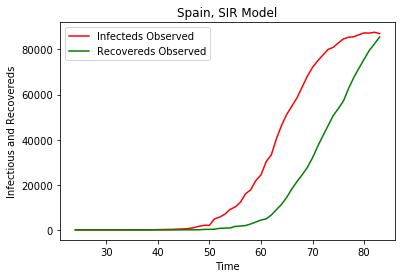

In [8]:
#Ploting
pl.plot(infected_observed, '-r', label='Infecteds Observed')
pl.plot(removed_observed, '-g', label='Recovereds Observed')

pl.legend(loc=0)
pl.title(chosen_country+', SIR Model')
pl.xlabel('Time')
pl.ylabel('Infectious and Recovereds')

## Iteratible SIR Model

In [9]:
t_start = 0.0
t_end = len(removed_observed) + 1       # Transmit Time

N = population
R0 = removed_initial
I0 = infected_initial      # Initial Number of Infectious
S0 = N - I0 - R0    # Initial Number of Susceptible

INPUT = (S0, I0, R0)

def model_SIR(INP,t):  
    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1]/N                    # Y[0] is dS(t)/dt, V[0] is S(t)
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]       # Y[1] is dI(t)/dt, V[1] is I(t)
    Y[2] = gamma * V[1]                            # Y[2] is dR(t)/dt.
    return Y   # For odeint

t_range = np.arange(t_start, t_end)

### Start Interation

In [10]:
start = time.time()

minimum_infected = math.pow(10,10)
minimum_removed = math.pow(10,10)

for gamma in np.arange(0.01, 5.0, 0.01):
    for beta in np.arange(0.01, 5.0, 0.01):
        RES = spi.odeint(model_SIR, INPUT, t_range) 
        
        # Goodness Test of Fitness
        
        #print(RES)
        
        fitness_infected = stats.chisquare(infected_observed, RES[1:, 1])
        fitness_removed = stats.chisquare(removed_observed, RES[1:, 2])
        
       
        if abs(fitness_infected[0]) < 10000 and abs(fitness_removed[0]) < 10000:
            print('\nbeta=', beta, '  gamma=', gamma, fitness_infected, fitness_removed)
        
        
        #print('beta=', beta, '  gamma=', gamma, fitness_infected, fitness_removed)
            
        if abs(fitness_infected[0]) < minimum_infected and abs(fitness_removed[0]) < minimum_removed:
            minimum_infected = fitness_infected[0]
            minimum_removed = fitness_removed[0]
            beta_mini = beta
            gamma_mini = gamma
            
end = time.time()
duration = end - start
            
print('\nThe minimum_infected Z is ', minimum_infected)
print('The minimum_removed Z is ', minimum_removed)
print('when beta is ', beta_mini)
print('when gamma is ', gamma_mini)

print('Time: ', duration)


The minimum_infected Z is  2752059.3859025002
The minimum_removed Z is  425312.5516375822
when beta is  0.29000000000000004
when gamma is  0.08
Time:  441.5925896167755


## SIR Validation

In [11]:
beta = beta_mini
gamma = gamma_mini

t_start = 0.0
t_end = 200      # Transmit Time

N = population
R0 = removed_initial
I0 = infected_initial  # Initial Number of Infectious
S0 = N - I0 - R0    # Initial Number of Susceptible

INPUT = (S0, I0, R0)

In [12]:
def model_SIR(INP,t):  
    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1]/N                    # Y[0] is dS(t)/dt, V[0] is S(t)
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]       # Y[1] is dI(t)/dt, V[1] is I(t)
    Y[2] = gamma * V[1]                            # Y[2] is dR(t)/dt.
    return Y   # For odeint


In [13]:
def calculate_maximum(RES):
    infected_maximum = 0
    infected_delta_maximum = 0
    day = 0
    infected_yesterday = 0
    
    for daily_value in RES:
        if daily_value[1] > infected_maximum:
            infected_maximum = daily_value[1]
            day_maximum = day
            
        if daily_value[1]-infected_yesterday > infected_delta_maximum:
            infected_delta_maximum = daily_value[1]-infected_yesterday
            day_inflection = day
            
        day = day + 1
        infected_yesterday = daily_value[1]
        
    return infected_maximum, day_maximum, infected_delta_maximum, day_inflection        

In [14]:
t_range = np.arange(t_start, t_end)

RES = spi.odeint(model_SIR, INPUT, t_range)   # INPUT is the first parameter of func diff_eqs
                                             # t_range is the second parameter of func diff_eqs

In [15]:
peak_infected, peak_day, peak_new, inflection_day = calculate_maximum(RES)

print('Peak Infected: ', f"{int(peak_infected):,d}")
print('Peak Day: ', peak_day)
print('New Case Increase Mostly: ',  f"{int(peak_new):,d}")
print('Inflection Day: ', inflection_day)


Peak Infected:  17,336,755
Peak Day:  86
New Case Increase Mostly:  1,178,515
Inflection Day:  77


Text(0, 0.5, 'Infectious and Recovereds')

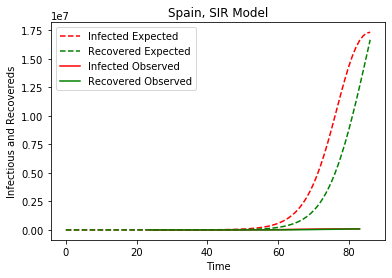

In [16]:
#Ploting
day = start_count_day + len(removed_observed) + 3
pl.plot(RES[:day,1], '--r', label='Infected Expected')
pl.plot(RES[:day,2], '--g', label='Recovered Expected')
pl.plot(infected_observed, '-r', label='Infected Observed')
pl.plot(removed_observed, '-g', label='Recovered Observed')

pl.legend(loc=0)
pl.title(chosen_country + ', SIR Model')
pl.xlabel('Time')
pl.ylabel('Infectious and Recovereds')

Text(0, 0.5, 'Infectious and Recovereds')

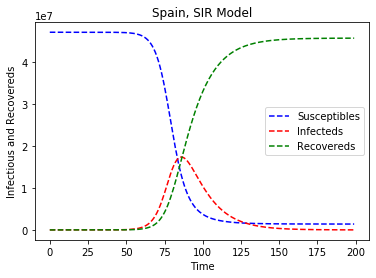

In [17]:
#Ploting
pl.plot(RES[:,0], '--b', label='Susceptibles')
pl.plot(RES[:,1], '--r', label='Infecteds')
pl.plot(RES[:,2], '--g', label='Recovereds')

pl.legend(loc=0)
pl.title(chosen_country + ', SIR Model')
pl.xlabel('Time')
pl.ylabel('Infectious and Recovereds')